<a href="https://colab.research.google.com/github/Henil21/University-Research/blob/main/ITM_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MRI Classification using CNN
**Index**

```
1. Fetching data ⛅
2. Helper function for visualizing  our data 🆘
3. visualizing the training data distribution 🔎
4. pre processing ⚙
5. Lets step into modeling 🕺
6. Helperfunction for plotting loss curves 📉
7. Adam V/S RMSprop 🤜
```
```
2.0  Brain MRI Classification 🧠
2.1  visualizing  our data 🔍
2.2  pre processing ⚙
2.3 Model Building 🕺
2.4 Plottin Loss 📉
```

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi  -L
# making sure GPU is connected ✅

GPU 0: Tesla T4 (UUID: GPU-dd00f08c-82db-68e3-945b-31081daa8f38)


##*1 Getting the data ⛅*

In [3]:
#fetching the data from cloud
Chest_train='/content/drive/MyDrive/Chest/'
Chest_test='/content/drive/MyDrive/Chest-Test'

In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_score(true_labels,predicted_labels):



    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

##2  *Helper function for Visualizing*🆘

In [5]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def view_random_image(target_dir,target_class):

   # getting class vise dir link
   target=target_dir+target_class

   # taking 1 random image from a list of all images under a class
   random_img=random.sample(os.listdir(target),1)

   #as we have stored it in list we need to access it through index which is zero
   image=mpimg.imread(target+'/'+random_img[0])

   fig = plt.figure(figsize=(5, 2))  # Set the width and height of the figure


   #plotting image
   plt.imshow(image)

   plt.axis("off")
   print(f"img shape:{image.shape}")

img shape:(200, 300, 3)


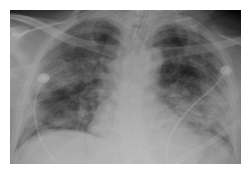

In [6]:
view_random_image(target_dir=Chest_train,target_class='COVID-19')

## 3 Lets visualize the distribution of the training data 🔍

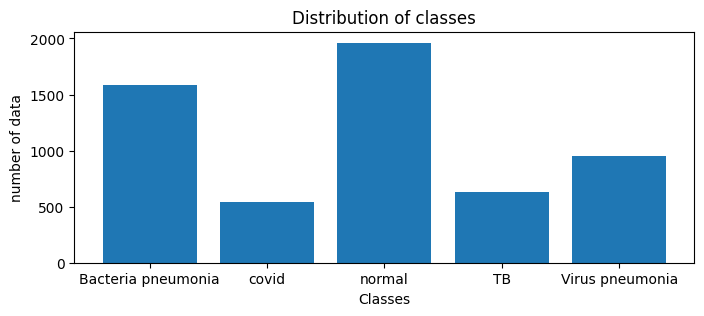

In [7]:

# getting length of the sub classes
BAC_n=len(os.listdir('/content/drive/MyDrive/Chest/Bacteria pneumonia'))
COVID=len(os.listdir('/content/drive/MyDrive/Chest/COVID-19'))
Normal=len(os.listdir('/content/drive/MyDrive/Chest/NORMAL'))
TB=len(os.listdir('/content/drive/MyDrive/Chest/Tuberculosis'))
virus_n=len(os.listdir('/content/drive/MyDrive/Chest/Virus pneumonia'))

classes=['Bacteria pneumonia', "covid",'normal','TB','Virus pneumonia']
values=[BAC_n,COVID,Normal,TB,virus_n]

fig = plt.figure(figsize=(8, 3))  # Set the width and height of the figure

plt.bar(classes,values)

# Adding title to the plot
plt.title("Distribution of classes")

# Adding label on the y-axis
plt.ylabel('number of data')

# Adding label on the x-axis
plt.xlabel('Classes')

plt.show()

## 4.Pre-processing ⚙

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# recaling pixels
train_data_gen = ImageDataGenerator(rescale=1./255,
                                   )

# dividing into batches and
train_generator = train_data_gen.flow_from_directory(
    Chest_train,
    target_size=(224,224), #targeted shape
    batch_size=(32),#32  images per batch
    shuffle=True,
    seed=42,
    class_mode='categorical', # we are working with multiclass problem

)


# recaling pixels
test_data_gen = ImageDataGenerator(rescale=1./255
                                                              )

# dividing into batches and
test_generator = train_data_gen.flow_from_directory(
    Chest_test,
    target_size=(224, 224), #targeted shape
    batch_size=(32),#32  images per batch
     shuffle=False,
     seed=42,
    class_mode='categorical',# we are working with multiclass problem

)

Found 5669 images belonging to 5 classes.
Found 1395 images belonging to 5 classes.


In [9]:
import os

# Specify the path to the directory you want to list subdirectories for
directory_path = '/content/drive/MyDrive/Chest-Test'

# Use the os.listdir() function to get a list of all items (files and directories) in the specified directory
items = os.listdir(directory_path)

# Iterate over the items and check if they are directories
subdirectories = []
for item in items:
    item_path = os.path.join(directory_path, item)
    if os.path.isdir(item_path):
        subdirectories.append(item)

# Print the list of subdirectories
print(subdirectories)


['Tuberculosis', 'COVID-19', 'NORMAL', 'Bacteria pneumonia', 'Virus pneumonia']


In [10]:
# import os
# import matplotlib.pyplot as plt
# import random

# # Assuming your images are organized in folders, where each folder represents a specific class label
# data_dir = '/content/drive/MyDrive/Brain_multiclass/Training'  # Specify the path to your dataset directory

# class_folders = os.listdir(data_dir)  # Get the list of class folders

# selected_images = []  # List to store the selected images

# for class_folder in class_folders:
#     class_path = os.path.join(data_dir, class_folder)  # Get the path of the current class folder
#     image_files = os.listdir(class_path)  # Get the list of image files in the current class folder
#     selected_file = random.choice(image_files)  # Select a random image file
#     selected_image_path = os.path.join(class_path, selected_file)  # Get the path of the selected image
#     selected_images.append((selected_image_path, class_folder))  # Add the selected image path and its class folder name

# fig, axs = plt.subplots(1, len(selected_images), figsize=(8, 4))  # Create subplots

# for i, (image_path, class_folder) in enumerate(selected_images):
#     image = plt.imread(image_path)  # Load the image from the path
#     axs[i].imshow(image)  # Show the image
#     axs[i].axis('off')  # Turn off axis labels
#     axs[i].set_title(class_folder)  # Set the title as the class folder name

# plt.tight_layout()  # Adjust spacing between subplots
# plt.show()  # Display the figure


> we got 5669 images divided into 5 sub-classes for training

> 1395 images divided into 5 sub-classes for testing

> total image [training+test]= 7064

run below cell if u wanna see numeric representation

In [11]:
# train_generator[0]

## **5. Lets step into modeling 🕺**

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPool2D, Activation
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import Sequential


tf.random.set_seed(42) #why 42? because it is Answer to the Ultimate Question of Life, the Universe, and Everything if you know you know

Model_1=Sequential([
    Conv2D(500,3,activation='relu', input_shape=(224,224,3)),  #3 is kernal size
    MaxPool2D(),
    Conv2D(250, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(250, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(5, activation='softmax') # softmax as we are working with multiclass problem
])


In [16]:
Model_1.compile(loss='categorical_crossentropy', # as we got multiple classes
                            optimizer=tf.keras.optimizers.RMSprop(), # for now lets dont specify the learning rate,  default is 0.001 and we will also try Rmspromp
                            metrics=['accuracy'])# evaluation


In [17]:
history=Model_1.fit(train_generator,
                   epochs=10,
                    steps_per_epoch=len(train_generator ),
                   validation_data=(test_generator),
                   validation_steps=len(test_generator ))

Epoch 1/10
178/178 [==============================] - 1226s 7s/step - loss: 1.3579 - accuracy: 0.5327 - val_loss: 0.8204 - val_accuracy: 0.6581
Epoch 2/10
178/178 [==============================] - 97s 541ms/step - loss: 0.8356 - accuracy: 0.6837 - val_loss: 0.6656 - val_accuracy: 0.7384
Epoch 3/10
178/178 [==============================] - 97s 542ms/step - loss: 0.7746 - accuracy: 0.7425 - val_loss: 0.6155 - val_accuracy: 0.7649
Epoch 4/10
178/178 [==============================] - 100s 564ms/step - loss: 0.5517 - accuracy: 0.7881 - val_loss: 0.4356 - val_accuracy: 0.8251
Epoch 5/10
178/178 [==============================] - 97s 543ms/step - loss: 0.4911 - accuracy: 0.8218 - val_loss: 0.4539 - val_accuracy: 0.8165
Epoch 6/10
178/178 [==============================] - 97s 542ms/step - loss: 0.3823 - accuracy: 0.8520 - val_loss: 0.3825 - val_accuracy: 0.8559
Epoch 7/10
178/178 [==============================] - 100s 564ms/step - loss: 0.3121 - accuracy: 0.8827 - val_loss: 0.4090 - val_a

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPool2D, Activation
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import Sequential

from tensorflow.keras.applications import VGG19
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add the pre-trained VGG-19 as a feature extractor
model = Sequential()
model.add(base_model)

# Add custom top layers for the new task
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))  # num_classes is the number of classes in your new task
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_vgg=model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

80134624/80134624 [==============================] - 1s 0us/step
Epoch 1/10
178/178 [==============================] - 49s 240ms/step - loss: 1.0947 - accuracy: 0.7033 - val_loss: 0.3962 - val_accuracy: 0.8265
Epoch 2/10
178/178 [==============================] - 37s 206ms/step - loss: 0.4195 - accuracy: 0.8340 - val_loss: 0.5917 - val_accuracy: 0.7778
Epoch 3/10
178/178 [==============================] - 40s 227ms/step - loss: 0.3478 - accuracy: 0.8615 - val_loss: 0.3282 - val_accuracy: 0.8659
Epoch 4/10
178/178 [==============================] - 40s 226ms/step - loss: 0.2997 - accuracy: 0.8785 - val_loss: 0.3833 - val_accuracy: 0.8452
Epoch 5/10
178/178 [==============================] - 40s 225ms/step - loss: 0.2528 - accuracy: 0.8989 - val_loss: 0.3040 - val_accuracy: 0.8566
Epoch 6/10
178/178 [==============================] - 38s 214ms/step - loss: 0.2229 - accuracy: 0.9146 - val_loss: 0.2566 - val_accuracy: 0.8767
Epoch 7/10
178/178 [==============================] - 37s 208ms/s

## 6.helperfunction for plotting loss curves 📉

In [ ]:
import pandas as pd
def plot_loss_curves(hist):
    pd.DataFrame(hist.history).plot(figsize=(5,5))

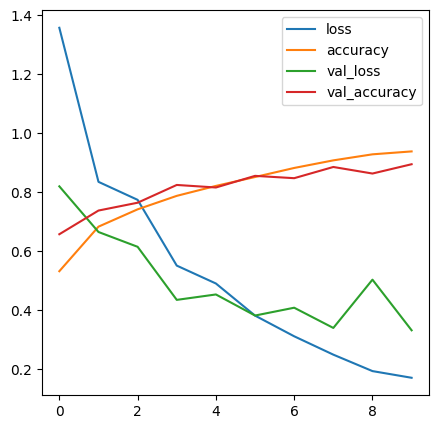

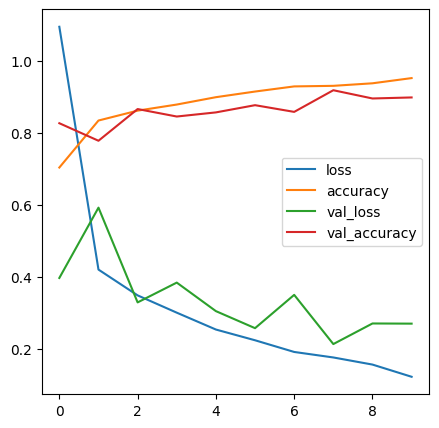

In [20]:
plot_loss_curves(history)
plot_loss_curves(history_vgg)

## 7.Adam V/S RMSprop 🤜

In [21]:
tf.random.set_seed(42)

Model_2=Sequential([
    Conv2D(500,3,activation='relu', input_shape=(224,224,3)),  #3 is kernal size
    MaxPool2D(),
    Conv2D(250, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(250, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(5, activation='softmax') # softmax as we are working with multiclass problem
])
Model_2.compile(loss='categorical_crossentropy' ,# as we got multiple classes
                            optimizer=tf.keras.optimizers.Adam(), # for now lets dont specify the learning rate,  default is 0.001 and we will also try Rmspromp
                            metrics=['accuracy'])# evaluation

history_2=Model_2.fit(train_generator,
                   epochs=10,
                    steps_per_epoch=len(train_generator ),
                   validation_data=(test_generator),
                   validation_steps=len(test_generator ))

Epoch 1/10
178/178 [==============================] - 101s 560ms/step - loss: 0.9846 - accuracy: 0.6185 - val_loss: 0.7185 - val_accuracy: 0.7133
Epoch 2/10
178/178 [==============================] - 95s 535ms/step - loss: 0.6427 - accuracy: 0.7462 - val_loss: 0.5040 - val_accuracy: 0.7821
Epoch 3/10
178/178 [==============================] - 95s 532ms/step - loss: 0.5388 - accuracy: 0.7869 - val_loss: 0.5377 - val_accuracy: 0.7878
Epoch 4/10
178/178 [==============================] - 95s 532ms/step - loss: 0.4486 - accuracy: 0.8252 - val_loss: 0.4203 - val_accuracy: 0.8179
Epoch 5/10
178/178 [==============================] - 95s 532ms/step - loss: 0.3630 - accuracy: 0.8545 - val_loss: 0.3587 - val_accuracy: 0.8616
Epoch 6/10
178/178 [==============================] - 95s 532ms/step - loss: 0.3110 - accuracy: 0.8815 - val_loss: 0.4378 - val_accuracy: 0.8215
Epoch 7/10
178/178 [==============================] - 95s 533ms/step - loss: 0.2540 - accuracy: 0.9014 - val_loss: 0.3445 - val_a

In [ ]:
plot_loss_curves(history_2)

In [22]:

import numpy as np
y_pred=Model_2.predict(test_generator)
yy_pred=model.predict(test_generator)
yy_pred=np.argmax(yy_pred,axis=-1)
y_pred=np.argmax(y_pred,axis=-1)
yyy_pred=Model_1.predict(test_generator)
yyy_pred=np.argmax(yyy_pred,axis=-1)

44/44 [==============================] - 6s 142ms/step


In [29]:

y_true=test_generator.labels



import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


class_labels = list(test_generator.class_indices.keys())
# y_pred=np.sort(y_pred)
confusion_mtx = confusion_matrix(y_true, yy_pred)

report = classification_report(y_true, yy_pred, target_names=class_labels)
print(report)

                    precision    recall  f1-score   support

Bacteria pneumonia       0.95      0.70      0.80       344
          COVID-19       0.90      0.97      0.93        93
            NORMAL       1.00      0.96      0.98       697
      Tuberculosis       0.96      1.00      0.98        70
   Virus pneumonia       0.62      0.97      0.76       191

          accuracy                           0.90      1395
         macro avg       0.88      0.92      0.89      1395
      weighted avg       0.92      0.90      0.90      1395



In [ ]:

y_true=test_generator.labels



import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


class_labels = list(test_generator.class_indices.keys())
# y_pred=np.sort(y_pred)
confusion_mtx = confusion_matrix(y_true, yy_pred)

report = classification_report(y_true, yy_pred, target_names=class_labels)
print(report)

In [26]:

y_true=test_generator.labels



import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


class_labels = list(test_generator.class_indices.keys())
# y_pred=np.sort(y_pred)
confusion_mtx = confusion_matrix(y_true, y_pred)

report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

                    precision    recall  f1-score   support

Bacteria pneumonia       0.86      0.76      0.80       344
          COVID-19       0.99      0.88      0.93        93
            NORMAL       0.97      0.95      0.96       697
      Tuberculosis       0.97      0.94      0.96        70
   Virus pneumonia       0.68      0.91      0.78       191

          accuracy                           0.89      1395
         macro avg       0.89      0.89      0.89      1395
      weighted avg       0.90      0.89      0.89      1395



In [28]:

y_true=test_generator.labels



import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

class_labels = list(test_generator.class_indices.keys())

confusion_mtx = confusion_matrix(y_true, yyy_pred)

report = classification_report(y_true, yyy_pred, target_names=class_labels)
print(report)

                    precision    recall  f1-score   support

Bacteria pneumonia       0.93      0.69      0.79       344
          COVID-19       0.92      0.91      0.92        93
            NORMAL       0.97      0.98      0.97       697
      Tuberculosis       0.99      0.96      0.97        70
   Virus pneumonia       0.65      0.94      0.77       191

          accuracy                           0.90      1395
         macro avg       0.89      0.90      0.88      1395
      weighted avg       0.91      0.90      0.90      1395



In [ ]:
# calculate_score(y_true,y_pred)

#2.0  Brain MRI Classification 🧠

In [ ]:
Brain_train='/content/drive/MyDrive/Brain_multiclass/Training/'
Brain_test='/content/drive/MyDrive/Brain_multiclass/Testing/'

## 2.1 visualizing  our data **🔍**

In [ ]:
view_random_image(target_dir=Brain_train,target_class='meningioma')

In [ ]:

# getting length of the sub classes
gol=len(os.listdir('/content/drive/MyDrive/Brain_multiclass/Training/glioma'))
men=len(os.listdir('/content/drive/MyDrive/Brain_multiclass/Training/meningioma'))
Normal=len(os.listdir('/content/drive/MyDrive/Brain_multiclass/Training/notumor'))
pit=len(os.listdir('/content/drive/MyDrive/Brain_multiclass/Training/pituitary'))

classes=['glioma', "meningioma",'normal','pituitary']
values=[gol,men,Normal,pit]

fig = plt.figure(figsize=(8, 3))  # Set the width and height of the figure

plt.bar(classes,values)

# Adding title to the plot
plt.title("Distribution of classes")

# Adding label on the y-axis
plt.ylabel('number of data')

# Adding label on the x-axis
plt.xlabel('Classes')

plt.show()

## 2.2 Pre-processing ⚙

In [ ]:
# train_generator[0]


## 2.3 Model Building 🕺

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPool2D, Activation
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import Sequential
tf.random.set_seed(42)

Model_2=Sequential([
    Conv2D(500,3,activation='relu', input_shape=(224,224,3)),  #3 is kernal size
    MaxPool2D(),
    Conv2D(250, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(250, 3, activation='relu'),
    MaxPool2D(),

    Flatten(),
    Dense(4, activation='softmax') # softmax as we are working with multiclass problem
])
Model_2.compile(loss='categorical_crossentropy', # as we got multiple classes
                            optimizer=tf.keras.optimizers.Adam(), # for now lets dont specify the learning rate,  default is 0.001 and we will also try Rmspromp
                            metrics=['accuracy'])# evaluation

history_2=Model_2.fit(train_generator_brain,
                   epochs=5,
                    steps_per_epoch=len(# dividing into batches and
                  train_generator_brain  ),
                   validation_data=(test_generator_brain),
                   validation_steps=len(test_generator_brain ))

## 2.4 Plottin Loss 📉

In [ ]:
plot_loss_curves(history_2)

## 2.5 RMSprop

In [ ]:
model_3=Sequential([
    Conv2D(500,3,activation='relu', input_shape=(224,224,3)),  #3 is kernal size
    MaxPool2D(),
    Conv2D(250, 3, activation='relu'),
    MaxPool2D(),
     Conv2D(250, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(4, activation='softmax') # softmax as we are working with multiclass problem
])
# we clone the above model  architecture
model_3.compile(loss='categorical_crossentropy', # as we got multiple classes
                            optimizer=tf.keras.optimizers.RMSprop(), # for now lets dont specify the learning rate,  default is 0.001 and we will also try Rmspromp
                            metrics=['accuracy'])# evaluation

history_3=Model_2.fit(train_generator_brain,
                   epochs=5,
                    steps_per_epoch=len(# dividing into batches and
                  train_generator_brain  ),
                   validation_data=(test_generator_brain),
                   validation_steps=len(test_generator_brain ))